In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random

In [2]:
def feature_scale(x):
    x = tf.cast(x,dtype=tf.float32)
    return x

In [3]:
data = np.load('TibetanMNIST.npz',mmap_mode='r')
data.files

['image', 'label']

In [4]:
x_data = data['image']
y_data = data['label']

print('x_data.shape:',x_data.shape)
print('y_data.shape:',y_data.shape)

x_data.shape: (12000, 28, 28)
y_data.shape: (12000,)


In [5]:
# specify a threshold 0-255
threshold = 127

for i in range(len(x_data)):
    # make all pixels < threshold black
    x_data[i] = 1.0 * (x_data[i] > threshold)

x_train = tf.data.Dataset.from_tensor_slices(x_data)

x_test = x_train.map(feature_scale).batch(len(x_train))
x_train = x_train.map(feature_scale).batch(128)


In [8]:


class VAE(keras.Model):
    def __init__(self):
        super(VAE,self).__init__()
        #encoder
        self.dim_reduce = 36
        self.fc_layer_1 = layers.Dense(128)
        self.fc_layer_2 = layers.Dense(self.dim_reduce)
        self.fc_layer_3 = layers.Dense(self.dim_reduce)

        self.fc_layer_4 = layers.Dense(128)
        self.fc_layer_5 = layers.Dense(784)
        

    def model_encoder(self, x):
        h = tf.nn.relu(self.fc_layer_1(x))
        mean_fc = self.fc_layer_2(h)
        var_fc = self.fc_layer_3(h)
        return mean_fc,var_fc

    def model_decoder(self, z):
        out = tf.nn.relu(self.fc_layer_4(z))
        out = self.fc_layer_5(out)
        return out

    def reparameter(self,mean_x,var_x):
        eps = tf.random.normal(var_x.shape)
        std = tf.exp(var_x)**0.5
        z = mean_x + std*eps
        return z

    def call(self, inputs, training=None):
        mean_x,var_x = self.model_encoder(inputs)
        z = self.reparameter(mean_x,var_x)
        x = self.model_decoder(z)
        return x,mean_x,var_x
    
    def predict(self, z):
        x = self.model_decoder(z)
        return x

## HW2-1  (λ=1)

In [9]:
λ=1.0

model = VAE()
optimizer = keras.optimizers.Adam(lr=0.001)
epoch = 30
loss_list=[]
for i in range(epoch):
    for step,x in enumerate(x_train):
        x = tf.reshape(x,[-1,784])
        with tf.GradientTape() as tape:
            logits,mean_x,var_x = model(x)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
            loss = tf.reduce_sum(loss)/x.shape[0]
            kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
            kl_div = tf.reduce_sum(kl_div)/x.shape[0]

            loss = loss + λ*kl_div
        grads = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        if step ==0:
            print('epoch:',i,'step:',step,'loss:',float(loss),'kl_div:',float(kl_div))
    loss_list.append(loss.numpy())

  
    

epoch: 0 step: 0 loss: 563.729736328125 kl_div: 8.387986183166504
epoch: 1 step: 0 loss: 274.10882568359375 kl_div: 20.25434112548828
epoch: 2 step: 0 loss: 225.95806884765625 kl_div: 27.06473159790039
epoch: 3 step: 0 loss: 204.1736602783203 kl_div: 29.258258819580078
epoch: 4 step: 0 loss: 190.721923828125 kl_div: 31.59200668334961
epoch: 5 step: 0 loss: 181.62448120117188 kl_div: 32.78438186645508
epoch: 6 step: 0 loss: 172.95785522460938 kl_div: 33.88555908203125
epoch: 7 step: 0 loss: 166.51702880859375 kl_div: 35.62354278564453
epoch: 8 step: 0 loss: 160.4681396484375 kl_div: 36.259063720703125
epoch: 9 step: 0 loss: 155.92437744140625 kl_div: 36.19487762451172
epoch: 10 step: 0 loss: 154.0277099609375 kl_div: 37.401554107666016
epoch: 11 step: 0 loss: 149.12359619140625 kl_div: 38.072288513183594
epoch: 12 step: 0 loss: 147.68814086914062 kl_div: 38.05592727661133
epoch: 13 step: 0 loss: 145.2443389892578 kl_div: 38.09050750732422
epoch: 14 step: 0 loss: 142.38133239746094 kl_di

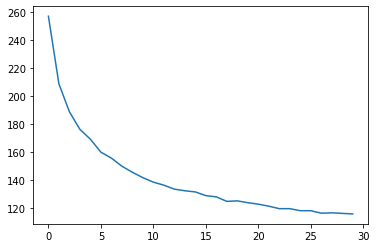

In [10]:
plt.plot(loss_list)

In [11]:
#TEST for Reconstruct
for x in x_test:
    val_x = tf.reshape(x,[-1,784])
    logits,_,_ = model(val_x)
    x_hat = tf.sigmoid(logits)
    x_hat = tf.reshape(x_hat,[-1,28,28])
    x_hat = x_hat.numpy()
    #x_hat = x_hat.astype(np.uint8)



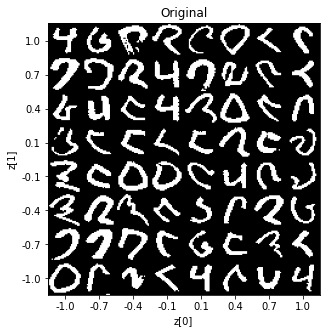

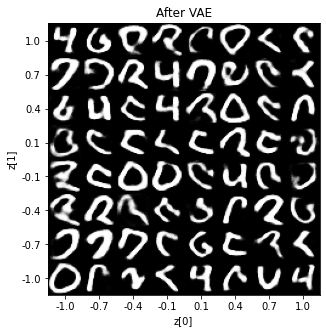

In [12]:
index_list = [random.randint(0,12000) for x in range(8*8)]

def plot(n=8, figsize=5):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i in range(n):
        for j in range(n):
            digit = x_data[index_list[n*i+j]]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Original')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
    for i in range(n):
        for j in range(n):
            digit = x_hat[index_list[n*i+j]]
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('After VAE')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot()

In [13]:
###############################################################

## HW2-2  (λ=1)

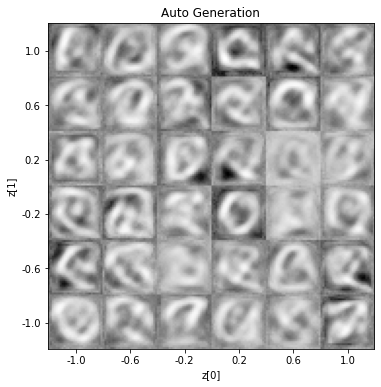

In [14]:


def generate_plot(vae,n=6, figsize=6):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            #random_z = np.array([np.random.normal(loc=np.mean(mean_x), scale=np.var(var_x),size=25)])
            random_z = np.array([np.random.normal(size=36)])
            random_z = tf.data.Dataset.from_tensor_slices(random_z)

            for z in random_z:
                z = tf.cast(z,dtype=tf.float32)
                z = tf.reshape(z,[-1,36])
                #z = model.reparameter(z,z)
                x = vae.model_decoder(z)
                #x = 1.0 * (x > threshold)
                digit = tf.reshape(x,[28,28])
                
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Auto Generation')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


generate_plot(model)

## HW2-3  (λ=1)

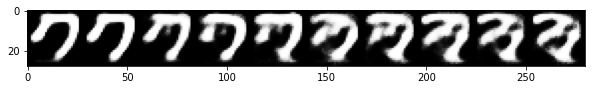

In [15]:
#set up the interpolation number
iprange = np.linspace(0,1,10)

def inter_plot(vae):
    digit_size=28
    n=10

    for x_random in x_test:
        real_x1 = x_random[random.randint(0,12000)]
        real_x2 = x_random[random.randint(0,12000)]

    figure = np.zeros((digit_size, digit_size*n ))

    for i, ip in enumerate(iprange):
        x = real_x1*ip + real_x2*(1-ip)
        val_x = tf.reshape(x,[-1,784])
        logits,_,_ = vae(val_x)
        x_hat = tf.sigmoid(logits)
        x_hat = tf.reshape(x_hat,[-1,28,28])
        x_hat = x_hat.numpy()  

        figure[
             0 : digit_size,
            i * digit_size : (i + 1) * digit_size,

        ] = x_hat

    plt.figure(figsize=(10, 5))

    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
inter_plot(model)

## HW2-1  (λ =5)

In [16]:
λ = 5.0

model2 = VAE()
optimizer = keras.optimizers.Adam(lr=0.001)
epoch = 30
loss_list=[]
for i in range(epoch):
    for step,x in enumerate(x_train):
        x = tf.reshape(x,[-1,784])
        with tf.GradientTape() as tape:
            logits,mean_x,var_x = model2(x)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
            loss = tf.reduce_sum(loss)/x.shape[0]
            kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
            kl_div = tf.reduce_sum(kl_div)/x.shape[0]

            loss = loss + λ*kl_div
        grads = tape.gradient(loss,model2.trainable_variables)
        optimizer.apply_gradients(zip(grads,model2.trainable_variables))
        if step ==0:
            print('epoch:',i,'step:',step,'loss:',float(loss),'kl_div:',float(kl_div))
    loss_list.append(loss.numpy())

  
    

epoch: 0 step: 0 loss: 589.3052368164062 kl_div: 7.8577752113342285
epoch: 1 step: 0 loss: 339.10723876953125 kl_div: 1.4541758298873901
epoch: 2 step: 0 loss: 318.39251708984375 kl_div: 2.5994503498077393
epoch: 3 step: 0 loss: 296.55267333984375 kl_div: 4.243755340576172
epoch: 4 step: 0 loss: 282.383544921875 kl_div: 5.554651260375977
epoch: 5 step: 0 loss: 271.6185302734375 kl_div: 6.447266578674316
epoch: 6 step: 0 loss: 264.6356201171875 kl_div: 7.1352338790893555
epoch: 7 step: 0 loss: 261.53045654296875 kl_div: 7.406573295593262
epoch: 8 step: 0 loss: 257.4275207519531 kl_div: 7.706966400146484
epoch: 9 step: 0 loss: 250.3782196044922 kl_div: 8.182271957397461
epoch: 10 step: 0 loss: 245.18385314941406 kl_div: 8.339651107788086
epoch: 11 step: 0 loss: 245.17913818359375 kl_div: 8.627277374267578
epoch: 12 step: 0 loss: 239.0840606689453 kl_div: 8.64035415649414
epoch: 13 step: 0 loss: 236.418701171875 kl_div: 9.024928092956543
epoch: 14 step: 0 loss: 233.819091796875 kl_div: 9.

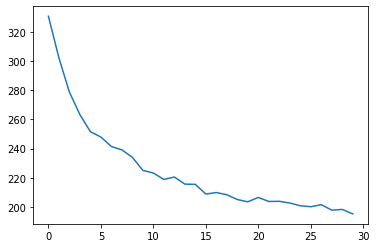

In [17]:
plt.plot(loss_list)

In [18]:
#TEST2 for Reconstruct
for x in x_test:
    val_x = tf.reshape(x,[-1,784])
    logits,_,_ = model2(val_x)
    x_hat2 = tf.sigmoid(logits)
    x_hat2 = tf.reshape(x_hat2,[-1,28,28])
    x_hat2 = x_hat2.numpy()


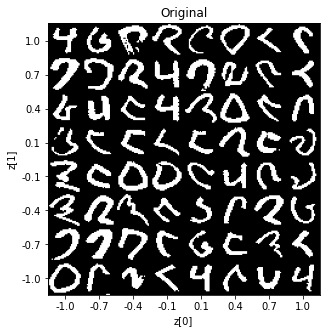

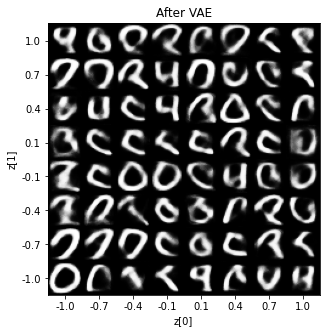

In [19]:
# index_list = [random.randint(0,12000) for x in range(8*8)]

def plot(n=8, figsize=5):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i in range(n):
        for j in range(n):
            digit = x_data[index_list[n*i+j]]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Original')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
    for i in range(n):
        for j in range(n):
            digit = x_hat2[index_list[n*i+j]]
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('After VAE')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot()

## HW2-2 (λ =5)

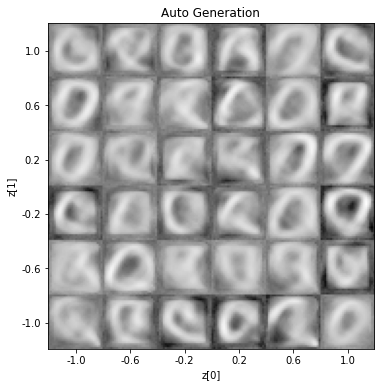

In [20]:
generate_plot(model2)

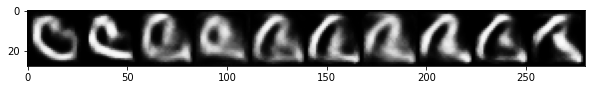

In [21]:
inter_plot(model2)